# Sugges_

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) data structure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on a trie;
3. Measure suggestion speed;
4. [M] Add spellcheck to suggest.


![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

## 0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [1]:
#!pip install pygtrie

### 0.1. Check it works and understand the example

In [2]:
import pygtrie
t = pygtrie.CharTrie()

# trie can be considered as a form of organizing a set of map
t["this is 1"] = "A"
t["this is 2"] = "B"
t["that is 3"] = "C"

print(t)

# "this" string is present in a set
n = t.has_node('this') == pygtrie.Trie.HAS_VALUE
# "this" prefix is present in a set
s = t.has_node('this') == pygtrie.Trie.HAS_SUBTRIE

print(f"Node = {n}\nSubtree = {s}")

# iterate a subtree
for key, val in t.iteritems("this"):
    print(key, '~', val)

CharTrie(this is 1: A, this is 2: B, that is 3: C)
Node = False
Subtree = True
this is 1 ~ A
this is 2 ~ B


## 1. Build a trie upon a dataset

### 1.1. [5] Read the dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset. Pass the assert.

In [3]:
import pandas as pd
#TODO: Read the dataset, e.g. as pandas dataframe
aol_data = pd.read_csv('./aol/user-ct-test-collection-01.txt.gz', sep='\t')

print("dataset size:", aol_data.shape[0])
assert aol_data.shape[0] == 3558411, "Dataset size does not match"

dataset size: 3558411


In [4]:
aol_data.head()


,AnonID,Query,QueryTime,ItemRank,ClickURL
0,142,rentdirect.com,2006-03-01 07:17:12,NaN,NaN
1,142,www.prescriptionfortime.com,2006-03-12 12:31:06,NaN,NaN
2,142,staple.com,2006-03-17 21:19:29,NaN,NaN
3,142,staple.com,2006-03-17 21:19:45,NaN,NaN
4,142,www.newyorklawyersite.com,2006-03-18 08:02:58,NaN,NaN


In [5]:
aol_data.tail()


,AnonID,Query,QueryTime,ItemRank,ClickURL
3558406,24968114,-,2006-05-31 01:04:20,NaN,NaN
3558407,24969251,sp.trafficmarketplace.com,2006-05-31 15:51:23,NaN,NaN
3558408,24969374,orioles tickets,2006-05-31 12:24:51,NaN,NaN
3558409,24969374,orioles tickets,2006-05-31 12:31:57,2.0,http://www.greatseats.com
3558410,24969374,baltimore marinas,2006-05-31 12:43:40,NaN,NaN


### 1.2. [10] Build a Trie

We want a suggest function to be **non-sensitive to stop words** because we don't want to upset the users if they confuses/omits prepositions. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build a Trie based on the dataset, **storing query statistics such as query _frequency_, urls and ranks in the nodes**. Some queries may have no associated urls, others may have multiple ranked urls. Think of the way to store this information.

Pass the asserts.

In [6]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def skip_stop_word(key):
    tokens=word_tokenize(key.lower())
    return " ".join([x for x in tokens if x not in stop_words])

aol_trie = pygtrie.CharTrie()

#TODO: build a trie based on the dataset

for index, row in aol_data.iterrows():
    query, rank, url=row['Query'], row['ItemRank'], row['ClickURL']
    #print(query)
    if pd.isna(query):
        continue
    clean_query=skip_stop_word(query)
    if clean_query not in aol_trie:
        aol_trie[clean_query]={}
        
    if query not in aol_trie[clean_query]:
        aol_trie[clean_query][query]=[1,{}]
    else:
        aol_trie[clean_query][query][0]+=1
        
    if not pd.isna(url) and not pd.isna(rank):
        aol_trie[clean_query][query][1][rank]=url 


In [7]:
# test trie
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)
    
    #NB: here we assume you store urls in a property of list type. But you can do something different. 
    for k,v in val.items():
        for kk,vv in v[1].items():
            bag.append(vv)
        
    #bag += val.urls
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ {'sample question surveys': [5, {7.0: 'http://www.surveyconnect.com', 4.0: 'http://www.custominsight.com', 10.0: 'http://www.askemployees.com', 1.0: 'http://www.lg-employers.gov.uk'}]}
sample questions immigration interview ~ {'sample questions for immigration interview': [1, {}]}
sample questions interview ~ {'sample questions for interview': [1, {1.0: 'http://www.quintcareers.com'}]}
sample questions family interview ~ {'sample questions for family interview': [3, {2.0: 'http://www.grandparents-day.com', 5.0: 'http://www.quintcareers.com', 3.0: 'http://jobsearchtech.about.com'}]}
sample questions sociology race ethnicity ~ {'sample questions sociology race and ethnicity': [1, {}]}
sample questions biology ~ {'sample questions biology': [2, {3.0: 'http://www.utexas.edu', 6.0: 'http://www.troy.k12.ny.us'}]}
sample questions us citizenship test ~ {'sample questions for us citizenship test': [1, {1.0: 'http://uscis.gov'}]}
sample questionarie teaching evaluation

## 2. [15] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Pass the asserts.

Question for analysis: What is the empirical threshold for minimal prefix for suggest?

In [8]:
stops = set('a on at of to is from for and with using the in &'.split())

In [9]:
from gensim.parsing.preprocessing import remove_stopwords

def complete_user_query(query: str, trie, top_k=5) -> list:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    result=[]
    res_queries=[]
    query = query.lower()
    query = remove_stopwords(query)
    try:
        for k, v in trie.iteritems(query):
            for kk in v:
                lst=v[kk]
                lst.append(kk)
                #print(lst)
                result.append(lst)
            
    except KeyError:
        print('No suggest for the query')
    
    result = sorted(result, key=lambda s:s[0], reverse=True)[:top_k]
    for r in result:
        frequency=r[0]
        q=r[2]
        if len(r[1])==0:
            url=" "
        else:
            #print('r1: ',r[1])
            urls = sorted(r[1].items(),reverse=True)
            #print('urls: ',urls)
            url=urls[0][1]
        print(f'Count {frequency}:     {q}        {url}')
        res_queries.append(q)
    print('----------------------------------------------------------')
    return res_queries
    

        
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie)
print(res)

#NB we assume you return suggested query string only
assert res[0] == "tried and true tattoo"
assert res[1] == "triest" or res[1] == "triethanalomine"

assert "boys and girls club of conyers georgia" \
            in complete_user_query("boys girls club conyers", aol_trie, 10), "Should be here"

Query: trie
Results:
Count 5:     tried and true tattoo        http://www.tattoonow.com
Count 3:     triest         
Count 3:     triethanalomine        http://www.amazon.com
Count 2:     tried and failed         
Count 2:     when you tried and failed         
----------------------------------------------------------
['tried and true tattoo', 'triest', 'triethanalomine', 'tried and failed', 'when you tried and failed']
Count 2:     boys and girls club of conyers georgia        http://www.bgcma.org
----------------------------------------------------------


## 3. Measure suggest speed ##

### 3.1. [10] Full Trie test

Check how fast your search is working. Consider changing your code if it takes too long on average.

Sucess criterion:
- there is an average and variance for **multiple runs** of the given bucket.
- there is an average and variance for **multiple runs** of naive search in unindexed dataset.

In [10]:
inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

#TODO: measure avg execution time (in milliseconds) per query and print it out
import time
import numpy as np
duration = []
for inp in inp_queries:
    start = time.time()
    print("Query:", inp)
    print("Results:")
    complete_user_query(inp, aol_trie)
    end = time.time()
    duration.append(end-start)
print(f'avg execution time in {np.mean(duration)} msec')

Query: inf
Results:
Count 94:     information clearing house        http://www.informationclearinghouse.info
Count 72:     information on training puppy        http://www.dogbreedinfo.com
Count 59:     inflatable slides         
Count 46:     infopass        http://uscis.gov
Count 40:     infolanka        http://www.infolanka.net
----------------------------------------------------------
Query: the best 
Results:
Count 685:     best buy        http://www.downloadsplaza.com
Count 257:     bestcounter.biz         
Count 224:     bestbuy        http://careers.bestbuy.com
Count 158:     bestbuy.com        http://blogs.zdnet.com
Count 99:     best western        http://www.bestwestern.co.uk
----------------------------------------------------------
Query: information retrieval
Results:
No suggest for the query
----------------------------------------------------------
Query: sherlock hol
Results:
Count 4:     sherlock holmes        http://en.wikipedia.org
Count 2:     sherlock holmes societ

### 3.2. [M][10] Assess how dataset size affect search time

Study the speed of the trie data structure in $\frac{1}{10}, \frac{1}{4}, \frac{1}{2}$, and full dataset. 
- Sample the data at random.
- Plot the graph which shows how search time changes with dataset size.
- Compare aganist bruteforce.

In [11]:
def build_trie(aol_data,size):
    aol_trie = pygtrie.CharTrie()
    for index, row in aol_data.iterrows():
        if index==size:
            print(index)
            break
        query, rank, url=row['Query'], row['ItemRank'], row['ClickURL']
        if pd.isna(query):
            continue
        clean_query=skip_stop_word(query)
        if clean_query not in aol_trie:
            aol_trie[clean_query]={}

        if query not in aol_trie[clean_query]:
            aol_trie[clean_query][query]=[1,{}]
        else:
            aol_trie[clean_query][query][0]+=1

        if not pd.isna(url) and not pd.isna(rank):
            aol_trie[clean_query][query][1][rank]=url 
    return aol_trie

In [12]:
def compute_executed_time(trie,inp):
    duration = []
    print("Query:", inp)
    print("Results:")
    complete_user_query(inp, trie)
    end = time.time()
    duration.append(end-start)

    print(f'avg execution time in {np.mean(duration)} msec')
    return np.mean(duration)

In [13]:
size1=int(aol_data.shape[0]*(1/10))
size2=int(aol_data.shape[0]*(1/4))
size3=int(aol_data.shape[0]*(1/2))
size4=int(aol_data.shape[0])

trie1=build_trie(aol_data,size1)
trie2=build_trie(aol_data,size2)
trie3=build_trie(aol_data,size3)
trie4=build_trie(aol_data,size4)

inp = "trie"
Avg_time1= compute_executed_time(trie1,inp)
Avg_time2= compute_executed_time(trie2,inp)
Avg_time3= compute_executed_time(trie3,inp)
Avg_time4= compute_executed_time(trie4,inp)

355841
889602
1779205
Query: trie
Results:
Count 1:     tried and truechildren's consignment sale         
----------------------------------------------------------
avg execution time in 2558.7274284362793 msec
Query: trie
Results:
Count 5:     tried and true tattoo        http://www.tattoonow.com
Count 3:     triest         
Count 1:     tried and truechildren's consignment sale         
Count 1:     i tried out the cycling class and the bike seat hurt my private area        http://www.bycycleinc.com
Count 1:     i tried to be perfect but nothing was worth it lyrics         
----------------------------------------------------------
avg execution time in 2558.730514526367 msec
Query: trie
Results:
Count 5:     tried and true tattoo        http://www.tattoonow.com
Count 3:     triest         
Count 1:     tried and truechildren's consignment sale         
Count 1:     i tried out the cycling class and the bike seat hurt my private area        http://www.bycycleinc.com
Count 1:     i t

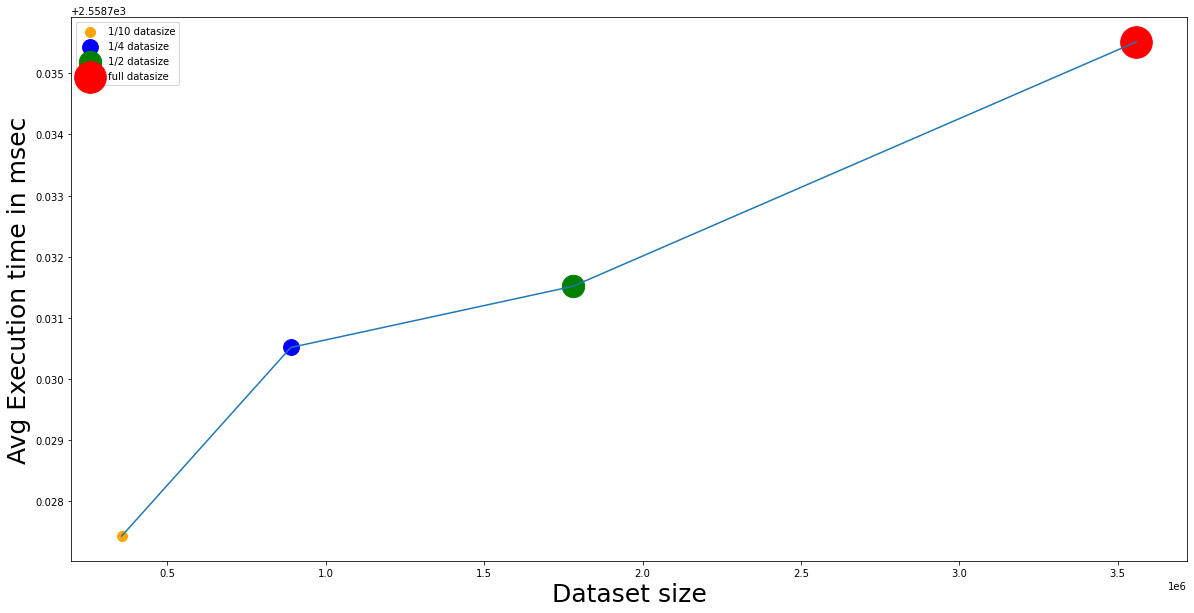

In [14]:
import matplotlib.pyplot as plt

### YOUR CODE HERE
x=[size1,size2,size3,size4]
y=[Avg_time1, Avg_time2, Avg_time3, Avg_time4]
plt.figure(figsize=(20,10))
plt.scatter(size1,Avg_time1,label='1/10 datasize',color='orange',s=100)
plt.scatter(size2,Avg_time2,label='1/4 datasize',color='blue',s=250)
plt.scatter(size3,Avg_time3,label='1/2 datasize',color='green',s=500)
plt.scatter(size4,Avg_time4,label='full datasize',color='red',s=1000)
plt.plot(x,y)
plt.xlabel('Dataset size',fontsize=25)
plt.ylabel('Avg Execution time in msec',fontsize=25)
plt.legend()
plt.show()


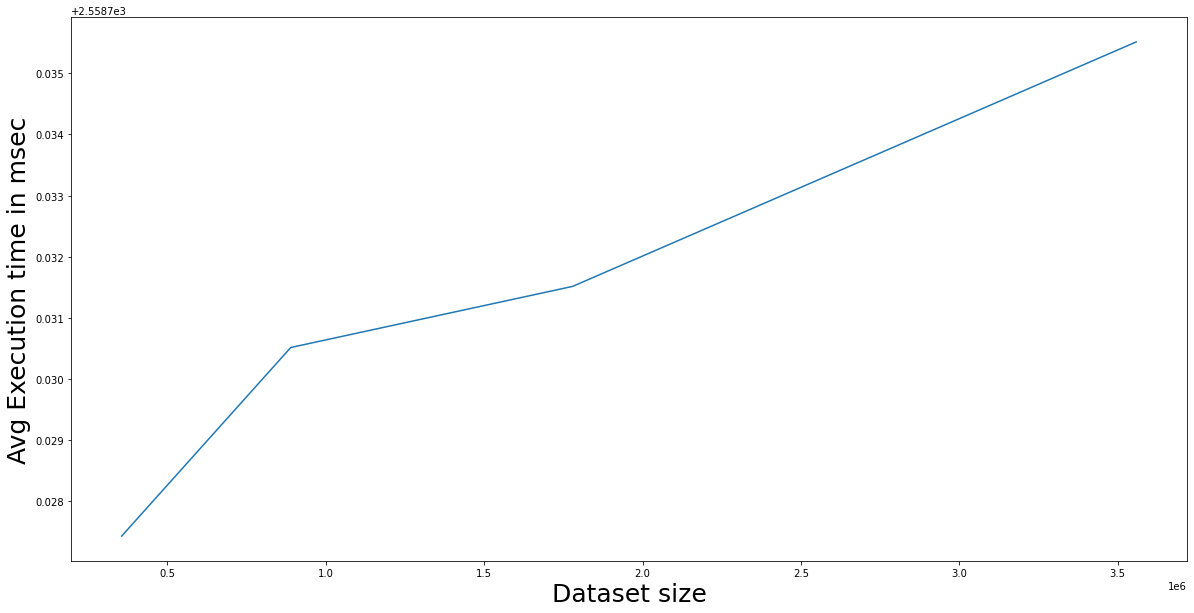

In [43]:


### YOUR CODE HERE
x=[size1,size2,size3,size4]
y=[Avg_time1, Avg_time2, Avg_time3, Avg_time4]
plt.figure(figsize=(20,10))

plt.plot(x,y)
plt.xlabel('Dataset size',fontsize=25)
plt.ylabel('Avg Execution time in msec',fontsize=25)

plt.show()


## 4. [10] Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

You can use use [pyspellchecker](https://pypi.org/project/pyspellchecker/) `candidates()` call, or use any other spellchecker implementation.

In [15]:
#! pip install pyspellchecker


In [16]:
from spellchecker import SpellChecker


In [17]:
spell = SpellChecker()
print(spell.candidates("inormation") ) 
print(spell.candidates("carnagie") )

{'information'}
{'carnegie', 'carnage'}


In [18]:
#!pip install pyenchant

In [19]:
from nltk.metrics import edit_distance
import enchant
class SpellingReplacer:
    def __init__(self, dict_name='en_GB', max_dist=2):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = 2

    def replace(self, word):
        if self.spell_dict.check(word):
            return word
        suggestions = self.spell_dict.suggest(word)

        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
            return suggestions[0]
        else:
            return word

In [20]:
def spell_check(word):
    replacer = SpellingReplacer()
    r = replacer.replace(word)
    return r

In [21]:
spell_check('inormation')

'information'

In [22]:
#!pip install textblob


In [23]:
from textblob import TextBlob
print(TextBlob("inormation retrieval").correct())
print(TextBlob("shelrock hol").correct())
print(TextBlob("carnagie mell").correct())
print(TextBlob("babis r").correct())
print(TextBlob("Barrbara").correct())


information retrieved
sherlock how
carnegie well
basis r
Barbara


In [24]:
#! pip install autocorrect

In [25]:
from autocorrect import Speller


In [26]:
spell = Speller(lang='en')
print(spell("inormation retrieval"))
print(spell("shelrock hol"))
print(spell("carnagie mell"))
print(spell("babis r"))
print(spell("Barrbara"))


information retrieval
sherlock hol
carnegie well
basis r
Barbara


In [27]:

def find_suggestions(trie,query,top_k=5):
    result=[]
    try:
        for k, v in trie.iteritems(query):
            for kk in v:
                lst=v[kk]
                lst.append(kk)
                result.append(lst)
    except KeyError:
        pass
    if len(result)!=0:
        result = sorted(result, key=lambda s:s[0], reverse=True)[:top_k]
    return result

In [28]:
def complete_user_query_with_spellchecker(query, trie, top_k=5) -> list:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    
    # using SpellChecker and candidates method
    spell = SpellChecker()
    
    query = skip_stop_word(query)
    query_lst=query.split()
    correct_query_lst=[]
    d={}
    for word in query_lst:
        if  len(word)==1:
            correct_query_lst.append(word)
        else:
            correct_word=spell.candidates(word)
            if len(correct_word)==1:
                correct_query_lst.append(correct_word.pop())
            else:
                #print(correct_word)
                for cw in  correct_word:
                    result=find_suggestions(trie,cw)
                    if len(result)!=0:
                        k=result[0][0]
                        d[k]=cw
                sorted_items = sorted(d.items(),reverse=True)
                correct_query_lst.append(sorted_items[0][1])
                
        
    result=find_suggestions(trie," ".join([x for x in correct_query_lst]))
    
    if len(result)==0:
        print('No suggest for the query')
        return result
    
    result = sorted(result, key=lambda s:s[0], reverse=True)[:top_k]
    res_queries=[]
    for r in result:
        frequency=r[0]
        q=r[2]
        if len(r[1])==0:
            url = " "
        else:
            urls = sorted(r[1].items(),reverse=True)
            url=urls[0][1]
        print(f'Count {frequency}:     {q}        {url}')
        res_queries.append(q)
    print('----------------------------------------------------------')
    return res_queries

In [29]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]
for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5), "Assert {} and {} give different results".format(q, qc)

No suggest for the query
----------------------------------------------------------
No suggest for the query
Count 4:     sherlock holmes        http://en.wikipedia.org
Count 2:     sherlock holmes society        http://www.sherlockian.net
Count 2:     sherlock holmes chronological order        http://www.geocities.com
Count 1:     sherlock holmes address         
Count 1:     sherlock holmes audiotapes         
----------------------------------------------------------
Count 4:     sherlock holmes        http://en.wikipedia.org
Count 2:     sherlock holmes society        http://www.sherlockian.net
Count 2:     sherlock holmes chronological order        http://www.geocities.com
Count 1:     sherlock holmes address         
Count 1:     sherlock holmes audiotapes         
----------------------------------------------------------
Count 6:     carnegie mellon        http://www.cmu.edu
Count 1:     carnegie mellon university        http://www.cmu.edu
--------------------------------------

## 5. [M][20] What if the query is in the middle?

Modify your code to suggest string even if the query is found **in the middle** of the text. Think about techniques you can borrow from our previous classes, e.g. about wildcard search.

E.g. `Semantic Parsing` in 

```
3DCNN-DQN-RNN: A Deep Reinforcement Learning Framework for Semantic Parsing of Large-scale 3D Point Clouds
                                                           ~~~~~~~~~~~~~~~~
```

**NB**: Please extend you trie-based approach. Even if using `in` and regexp can give you same result, this is not a scalable approach, which we will not accept.

Pass the asserts.

In [30]:
import itertools
import gc
gc.collect()
aol_data = pd.read_csv('./aol/user-ct-test-collection-01.txt.gz', sep='\t')

newtrie = pygtrie.CharTrie()

#TODO: build a trie based on the dataset

for index, row in aol_data.iterrows():
    queries_lst=[]
    query, rank, url=row['Query'], row['ItemRank'], row['ClickURL']
    #print(query)
    if pd.isna(query):
        continue
    clean_query=skip_stop_word(query)
    clean_query_lst=clean_query.split()
    queries_lst=[]
    l=len(clean_query_lst)
    for  i in range(l):
        queries_lst.append(" ".join(clean_query_lst[i:l+1]))
        
    
    for clean_query in queries_lst:
        if pd.isna(query):
            continue
        if clean_query not in newtrie:
            newtrie[clean_query]={}

        if query not in newtrie[clean_query]:
            newtrie[clean_query][query]=[1,{}]
        else:
            newtrie[clean_query][query][0]+=1

        if not pd.isna(url) and not pd.isna(rank):
            newtrie[clean_query][query][1][rank]=url 

In [31]:

## YOUR CODE HERE

def complete_user_query_with_spellchecker_and_middle(query, trie, top_k=5) -> list:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    result=complete_user_query_with_spellchecker(query, trie, top_k)
    return result


In [32]:
assert "ricky martin beach" in complete_user_query_with_spellchecker_and_middle(
            "martin beach", newtrie, 20)
assert "free adult movies" in  complete_user_query_with_spellchecker_and_middle(
            "adult movies", newtrie, 20)


Count 74:     ricky martin beach         
----------------------------------------------------------
Count 28:     adult movies        http://www.wickedpictures.com
Count 12:     previews adult movies        http://porn.iwantanewgirlfriend.com
Count 7:     free adult movies        http://www.jucygirls.com
Count 5:     virgin rape adult movies        http://www.westtorontojunction.com
Count 1:     alt adult movies        http://www.newsgroupservers.net
----------------------------------------------------------


In [33]:
assert ("free adult movie" in  suggests for result in complete_user_query_with_spellchecker_and_middle(
            "adult movie", newtrie, 20))

Count 28:     adult movies        http://www.wickedpictures.com
Count 12:     previews adult movies        http://porn.iwantanewgirlfriend.com
Count 7:     free adult movies        http://www.jucygirls.com
Count 5:     virgin rape adult movies        http://www.westtorontojunction.com
Count 4:     adult movie download         
----------------------------------------------------------


## 6. [M][20] Enrich your suggest with search results

Your users will be happy if at typing the query they will see not only suggested queries, but also snippets of the answers to these queries!

Imagine you type "continental air", and the search engine suggests you "continental airlines" together with the URL and snippet kind of `"Continental Airlines was a major American airline founded in 1934 and eventually headquartered in Houston, Texas..."`, which you borrow from the search engine snippet. How can you add existing search enginge to your code? [One](https://yandex.com/dev/xml/doc/dg/task/quickstart.html), [two](https://docs.microsoft.com/en-us/bing/search-apis/bing-web-search/search-the-web), [three](https://searx.roughs.ru/), ...

Improve your suggest. It should return a tuple of 3 instead on a string: `(query, text, url)`. Write your own tests which will for the query `continental air` return among the results:
1. `query` = `continental airlines`.
2. 
`Continental Airlines was a major American airline founded in 1934` in `text`.
3. `url` = `https://en.wikipedia.org/wiki/Continental_Airlines`.

In [34]:
#the same code of complete_user_query_with_spellchecker but  version2  to  return list queries  and urls
#at the end not only the queries
def complete_user_query_with_spellchecker_v2(query, trie, top_k=5) -> list:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    
    # using SpellChecker and candidates method
    spell = SpellChecker()
    
    query = skip_stop_word(query)
    query_lst=query.split()
    correct_query_lst=[]
    d={}
    for word in query_lst:
        if  len(word)==1:
            correct_query_lst.append(word)
        else:
            correct_word=spell.candidates(word)
            if len(correct_word)==1:
                correct_query_lst.append(correct_word.pop())
            else:
                #print(correct_word)
                for cw in  correct_word:
                    result=find_suggestions(trie,cw)
                    if len(result)!=0:
                        k=result[0][0]
                        d[k]=cw
                sorted_items = sorted(d.items(),reverse=True)
                correct_query_lst.append(sorted_items[0][1])
                
        
    result=find_suggestions(trie," ".join([x for x in correct_query_lst]))
    
    if len(result)==0:
        print('No suggest for the query')
        return result
    
    result = sorted(result, key=lambda s:s[0], reverse=True)[:top_k]
    res_queries=[]
    for r in result:
        frequency=r[0]
        q=r[2]
        if len(r[1])==0:
            url = " "
        else:
            urls = sorted(r[1].items(),reverse=True)
            url=urls[0][1]
        print(f'Count {frequency}:     {q}        {url}')
        res_queries.append([url,q])
    print('----------------------------------------------------------')
    return res_queries

In [35]:
#the same code of complete_user_query_with_spellchecker_and_middle but version2  to  return list queries  and urls
#at the end not only the queries
def complete_user_query_with_spellchecker_and_middle_v2(query, trie, top_k=5) -> list:
    #TODO: suggest top_k options for a user query
    # sort results by frequency (!!), 
    # suggest the QUERIES for first k ranked urls if available
    result=complete_user_query_with_spellchecker_v2(query, trie, top_k)
    return result

In [36]:
"""
import requests
from bs4 import BeautifulSoup

headers = {"Accept-Language": "en-US,en;q=1.0"}

params = {'q': query}

html = requests.get(f'https://www.google.com/search',
                    headers=headers,
                    params=params).text
soup = BeautifulSoup(html.text, "html.parser")

"""

'\nimport requests\nfrom bs4 import BeautifulSoup\n\nheaders = {"Accept-Language": "en-US,en;q=1.0"}\n\nparams = {\'q\': query}\n\nhtml = requests.get(f\'https://www.google.com/search\',\n                    headers=headers,\n                    params=params).text\nsoup = BeautifulSoup(html.text, "html.parser")\n\n'

In [37]:
import requests
from bs4 import BeautifulSoup


def complete_user_query_with_spellchecker_and_middle_with_snippets(query, trie, top_k=5)-> list:
    #TODO
    results=[]
    result=complete_user_query_with_spellchecker_and_middle_v2(query, trie, top_k=5)
    for r in result:
        url=r[0]
        query=r[1]
        if url==' ':
            continue
        headers = {"Accept-Language": "en-US,en;q=1.0"}
        params = {
        'q': query,
        'hl': 'en',
        }
        html = requests.get('https://www.google.com/search', headers=headers, params=params)
        soup = BeautifulSoup(html.text, "html.parser")
        snippet = soup.select_one("div:nth-child(1) > div > div:nth-child(1) > div > div > div > div").text
        t=(query,snippet,url)
        results.append(t)
        if snippet!='':
            print(f'Query: {query} \n Snippet: {snippet} \n Url= {url}')
            print('-----------------------------------------------------------------------')
    return results

In [38]:
results=complete_user_query_with_spellchecker_and_middle_with_snippets("free adult movie", newtrie, 5)


Count 7:     free adult movies        http://www.jucygirls.com
Count 2:     free adult movie trailer        http://www.hadafew.com
Count 1:     free adult movies clips         
Count 1:     free adult movies online         
Count 1:     free adult movie downloads         
----------------------------------------------------------
Query: free adult movies 
 Snippet: Speech on blockchain Free Adult Movies -2022年4月20日5时0分7秒rbl credit card paymentgccggg.com. 
 Url= http://www.jucygirls.com
-----------------------------------------------------------------------
Query: free adult movie trailer 
 Snippet: Jun 25, 2019 · 1992movietrailer #trailers #trailer #movietrailer #previewsFind More @ #cappazackTheatrical Trailer - https://youtu.be/BkVsrJUdzocTV Spot ... 
 Url= http://www.hadafew.com
-----------------------------------------------------------------------


In [39]:
results=complete_user_query_with_spellchecker_and_middle_with_snippets("continental airlines", newtrie, 5)


Count 363:     continental airlines        http://www.onepass.com
Count 43:     continental airlines.com        http://www.flycontinental.com
Count 4:     continental airlines arena seating chart        http://www.seatdata.com
Count 4:     http continental airlines.com        http://www.continental.com
Count 4:     continental airlinesl         
----------------------------------------------------------
Query: continental airlines 
 Snippet: Continental Airlines was a major American airline founded in 1934 and eventually headquartered in Houston, Texas. It had ownership interests and brand ... 
 Url= http://www.onepass.com
-----------------------------------------------------------------------
Query: continental airlines.com 
 Snippet: Find the latest travel deals on flights, hotels and rental cars. Book airline tickets and MileagePlus award tickets to worldwide destinations. 
 Url= http://www.flycontinental.com
-----------------------------------------------------------------------
Qu

In [40]:
results=complete_user_query_with_spellchecker_and_middle_with_snippets("continental airlin", newtrie, 5)


Count 363:     continental airlines        http://www.onepass.com
Count 43:     continental airlines.com        http://www.flycontinental.com
Count 30:     continental airline        http://www.continental.com
Count 4:     continental airlines arena seating chart        http://www.seatdata.com
Count 4:     http continental airlines.com        http://www.continental.com
----------------------------------------------------------
Query: continental airlines 
 Snippet: Continental Airlines was a major American airline founded in 1934 and eventually headquartered in Houston, Texas. It had ownership interests and brand ... 
 Url= http://www.onepass.com
-----------------------------------------------------------------------
Query: continental airlines.com 
 Snippet: Find the latest travel deals on flights, hotels and rental cars. Book airline tickets and MileagePlus award tickets to worldwide destinations. 
 Url= http://www.flycontinental.com
--------------------------------------------------

In [41]:
# YOUR TESTS HERE
assert ("free adult movie" in  suggests for result in complete_user_query_with_spellchecker_and_middle_with_snippets(
            "adult movie", newtrie, 20))


Count 28:     adult movies        http://www.wickedpictures.com
Count 12:     previews adult movies        http://porn.iwantanewgirlfriend.com
Count 7:     free adult movies        http://www.jucygirls.com
Count 5:     virgin rape adult movies        http://www.westtorontojunction.com
Count 4:     adult movie download         
----------------------------------------------------------
Query: adult movies 
 Snippet: Now take a load off for erotic movies ranked worst to best by Tomatometer! #200 ... script for a nuanced, mature film about neurosis and human sexuality. 
 Url= http://www.wickedpictures.com
-----------------------------------------------------------------------
Query: previews adult movies 
 Snippet: Featuring: Laura Gemser: legendary star of the Black Emanuelle series; Christina Lindberg: legendary star of Thriller and Sex & Fury; Brigitte Lahaie: legendary ... 
 Url= http://porn.iwantanewgirlfriend.com
----------------------------------------------------------------------